# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import shutil
from collections import Counter
import random
from tensorflow import keras
from keras import layers

### 1.Obtain the Data: Get the Dogs vs Cats dataset 

Here we are extracting the data from the data set and converting the large data set(25000) into small data set (5000 Images)

In [2]:

def select_first_n_images_and_create_structure(source_dir, dest_dir, n=2500): #Selecting the first 2500 images from the both cats and dogs
    
    total_old_images = count_images_in_dataset(source_dir)
    print("Total images in the old dataset:", total_old_images)

    for root, dirs, files in os.walk(source_dir):
        for dir in dirs:
            src_sub_dir = os.path.join(root, dir)
            dest_sub_dir = os.path.join(dest_dir, os.path.relpath(src_sub_dir, source_dir))
            os.makedirs(dest_sub_dir, exist_ok=True)

            image_paths = [os.path.join(src_sub_dir, filename) for filename in os.listdir(src_sub_dir)]
            selected_images = image_paths[:n]

            for image_path in selected_images:
                shutil.copy(image_path, dest_sub_dir)

    # Count the total number of images in the new dataset
    total_images = count_images_in_dataset(dest_dir)
    print("Total images in the new dataset:", total_images)

def count_images_in_dataset(dataset_dir):

    image_count = 0
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_count += 1
    return image_count #Returning the total number of images in the new data set 


source_directory = "C:/Users/ADMIN/Documents/Foundation-Machine-Learning-framework-/demo_vm/CSCN8010-labs/foundation-machine-learning-/PetImages" #Data set path
destination_directory = "C:/Users/ADMIN/Documents/Foundation-Machine-Learning-framework-/demo_vm/CSCN8010-labs/foundation-machine-learning-/new_dataset" # new dataset path

select_first_n_images_and_create_structure(source_directory, destination_directory, 2500) # Creating the new data set 

Total images in the old dataset: 24959
Total images in the new dataset: 5000


### 2.EDA: Explore the data with relevant graphs, statistics and insights 

#### 2.1.Class Distribution

To determine whether the data is balanced or skewed, plot the number of photos in each class (dogs vs. cats).

Class Distribution:
Cat: 2500 images
Dog: 2500 images


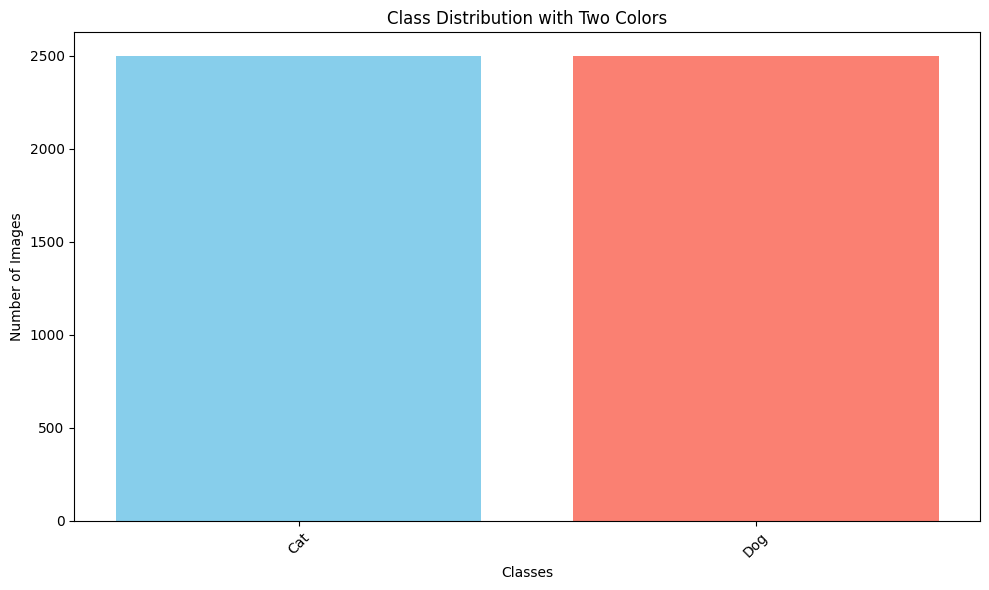

In [3]:
def calculate_class_distribution(dataset_dir): #Defining the function to count the distribution of data 
   
    class_counts = Counter() #Counting the classes 
     
    for root, dirs, files in os.walk(dataset_dir): #Checking each image in the dataset
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            class_counts[dir_name] += len(image_files)
    
    return class_counts #Returns the count

def plot_class_distribution_with_colors(class_counts):

    # Printing the statistics of the data 
    print("Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
    
    colors = ['skyblue', 'salmon']  # Define two colors for alternating classes
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=[colors[i % 2] for i in range(len(class_counts))])
    plt.xlabel("Classes") # X axis Label
    plt.ylabel("Number of Images") # Y axis Label
    plt.title("Class Distribution with Two Colors") # Title of the graph
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Calculate and plot class distribution
class_distribution = calculate_class_distribution(destination_directory)
plot_class_distribution_with_colors(class_distribution)



#### Statistics 
* Here the number of cat images present in the dataset are 2500 and number of dog images present in the data set are 2500.

* The bars would appear to equal in height if there were a comparable number of photographs for each class. There is no variation in the bar heights due to the same number of images present in each class. 

#### Insights 

* **Balanced Dataset:** With only a same in the quantity of photos in each class, this dataset is to be fairly balanced. When training machine learning models, a balanced dataset is best since it prevents the model from becoming biased in favor of the majority class.

* **Visualization Check:** A quick and simple method to visually confirm whether there is a class imbalance that could affect the performance of models, such as deep learning models, is to use a bar chart.

* **Potential Course of Action:**
Techniques like class weighting, oversampling the minority class, or undersampling the majority class may be used to assist the model learn evenly from both groups if we observe a significant imbalance.

#### 2.2.Sample Images

To gain a sense of the dataset visual style, we are displaying few pictures from each class.

Total Classes: 2
Total Images: 5000
Average Images per Class: 2500.00

Class with Most Images: Cat (2500 images)
Class with Least Images: Cat (2500 images)


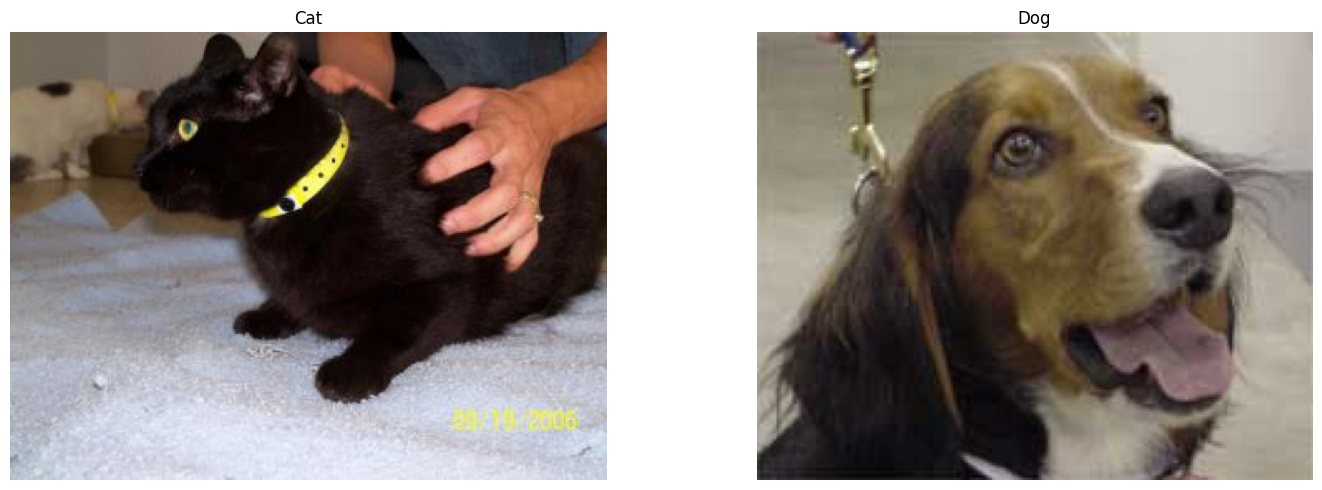

In [4]:
def calculate_class_statistics(dataset_dir): #Function for determining the statistics
    class_counts = Counter()
    sample_images = {}

    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            class_counts[dir_name] += len(image_files)
            if image_files:  # Save a random image path for the sample
                sample_images[dir_name] = os.path.join(class_dir, random.choice(image_files))
    
    return class_counts, sample_images

# determining the statistics
def display_statistics_and_insights(class_counts):
    
    total_classes = len(class_counts)
    total_images = sum(class_counts.values())
    avg_images_per_class = total_images / total_classes if total_classes > 0 else 0

    print(f"Total Classes: {total_classes}")
    print(f"Total Images: {total_images}")
    print(f"Average Images per Class: {avg_images_per_class:.2f}\n")

    max_class = max(class_counts, key=class_counts.get)
    min_class = min(class_counts, key=class_counts.get)
    print(f"Class with Most Images: {max_class} ({class_counts[max_class]} images)")
    print(f"Class with Least Images: {min_class} ({class_counts[min_class]} images)")

def display_sample_images(sample_images): #Function for displaying the sample images 

    plt.figure(figsize=(15, 5))
    for i, (class_name, image_path) in enumerate(sample_images.items()):
        try:
            img = Image.open(image_path)
            plt.subplot(1, len(sample_images), i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image for class {class_name}: {e}")
    plt.tight_layout()
    plt.show()

# Calculate statistics and display sample images
class_distribution, sample_images = calculate_class_statistics(destination_directory)

# Display Statistics and Insights
display_statistics_and_insights(class_distribution)

# Display Sample Images
display_sample_images(sample_images)


#### Statistics

* **Total Classes:** The unique categories in the dataset (e.g., cats, dogs).

* Indicates the diversity of the dataset.

* **Total Images:** The total count of images in all classes combined.

* Represents the dataset size.

* **Average Images per Class:** The mean number of images in each class (total_images ÷ total_classes).

* Helps gauge uniformity in class representation.

* **Class with Most Images:** The category with the highest number of images.

* Highlights potential dominance in the dataset.

* **Class with Least Images:** The category with the lowest number of images.

* Shows potential under-representation, which might require balancing.

* These statistics help assess the dataset balance, diversity, and adequacy for training machine learning models.

#### Insights

1. **Data Exploration:** A few sample photos from the collection can be visualized with the aid of this code. we may confirm the caliber, variety, and kinds of photos in each class (dogs and cats) by visually examining the sample photos.

2. **Random Sampling:** The pictures that are shown are selected at random. By ensuring that a range of photos are viewed, this random sample provides a broad overview of the dataset free from prejudice toward any particular images or classes.

3. **Noisy Data Insights:** By displaying random samples, we can identify possible problems with the dataset, such as images that are of poor quality (blurry, clipped, or damaged) or that might not meet the desired class (e.g., mislabeled images).

4. **Model Inputs:** We may get a sense of the type of data your model will handle by visualizing sample photographs. This aids in choosing the augmentation methods or preprocessing processes (like scaling) to use on the dataset.

5. **Balanced Dataset Check:** We may also get a sense of the diversity of the photographs within each class by looking at the sample images. This is helpful for identifying disparities in class or figuring out whether some courses have more diverse photos than others.

#### 2.3.Image Size Analysis

To determine whether resizing is required and to spot any irregularities, compile statistics on image dimensions.

Width Statistics:
Mean: 401.79619238476954
Median: 432.0
Mode: 500
Standard Deviation: 107.93363184521151
Min: 42
Max: 500

Height Statistics:
Mean: 366.7058116232465
Median: 375.0
Mode: 375
Standard Deviation: 96.32738528894987
Min: 37
Max: 500


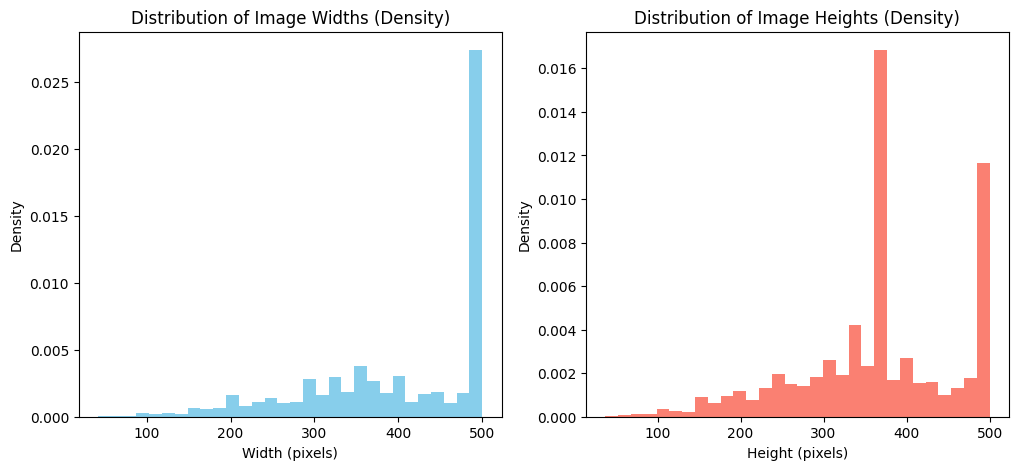

In [3]:
cat_dir = "C:/Users/ADMIN/Documents/Foundation-Machine-Learning-framework-/demo_vm/CSCN8010-labs/foundation-machine-learning-/new_dataset/Cat"
dog_dir = "C:/Users/ADMIN/Documents/Foundation-Machine-Learning-framework-/demo_vm/CSCN8010-labs/foundation-machine-learning-/new_dataset/Dog"
image_shapes = []

for img_file in os.listdir(cat_dir) + os.listdir(dog_dir): #Selecting the dog and cat images 
    try:
        img_path = os.path.join(cat_dir if 'Cat' in img_file else dog_dir, img_file)
        img = load_img(img_path)
        image_shapes.append(img.size)  # Append (width, height)
    except:
        pass  # Some files might be corrupted

# Converting to a NumPy array for easier manipulation
image_shapes = np.array(image_shapes)
widths, heights = image_shapes[:, 0], image_shapes[:, 1]

# Calculating the statistics for width and height
width_mean = np.mean(widths)
width_median = np.median(widths)
width_mode = np.argmax(np.bincount(widths))
width_std = np.std(widths)
width_min = np.min(widths)
width_max = np.max(widths)

height_mean = np.mean(heights)
height_median = np.median(heights)
height_mode = np.argmax(np.bincount(heights))
height_std = np.std(heights)
height_min = np.min(heights)
height_max = np.max(heights)

# Printing the statistics for width and height
print(f"Width Statistics:")
print(f"Mean: {width_mean}")
print(f"Median: {width_median}")
print(f"Mode: {width_mode}")
print(f"Standard Deviation: {width_std}")
print(f"Min: {width_min}")
print(f"Max: {width_max}")

print("\nHeight Statistics:")
print(f"Mean: {height_mean}")
print(f"Median: {height_median}")
print(f"Mode: {height_mode}")
print(f"Standard Deviation: {height_std}")
print(f"Min: {height_min}")
print(f"Max: {height_max}")


# Plotting distributions of width with density
plt.figure(figsize=(12, 5))

# Plotting density for width 
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', density=True)
plt.title('Distribution of Image Widths (Density)')
plt.xlabel('Width (pixels)')
plt.ylabel('Density')

# Plotting density for height
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', density=True)
plt.title('Distribution of Image Heights (Density)')
plt.xlabel('Height (pixels)')
plt.ylabel('Density')

plt.show()

#### Statistics 

1. **Width Statistics:**

* **Mean(401.79 pixels):** The average width of the images is 401.79 pixels, indicating that the images in the dataset are generally large in width.

* **Median (432.0 pixels):** The median value is slightly higher than the mean, suggesting that the data might be right-skewed, with some images being much larger than the rest.

* **Mode(500 pixels):** The most frequent width among the images is 500 pixels. This shows that a large proportion of images have a width of 500 pixels, indicating that many images are standardized or resized to this dimension.

* **Standard Deviation (107.93 pixels):** The high standard deviation indicates that there is considerable variation in the width of the images. While many images are around 500 pixels, there are others significantly smaller, causing this spread.

* **Min(42 pixels)** The smallest image width is 50 pixels, which could indicate smaller images or possibly corrupted ones (if this is an unintended value).

* **Max(500 pixels):** The largest image width is 500 pixels, aligning with the mode. This suggests that 500 pixels might be the intended standard for the images in the dataset.

2. **Height Statistics:**

* **Mean( 366.70 pixels):** The average height is 358.02 pixels, which is slightly lower than the width. This suggests that the images might be relatively wider than they are tall.

* **Median(375.0 pixels):** The median height is very close to the mean, suggesting that the height distribution is fairly symmetric with no extreme skewness.

* **Mode(375 pixels):** The most frequent height is 375 pixels, indicating that many of the images share this height.

* **Standard Deviation(96.32 pixels):** A similar standard deviation to width, suggesting a relatively high variation in image height, although slightly less than the width.

* **Min(30 pixels):** Similar to the width, the smallest image height is 50 pixels, which could also be indicative of smaller or corrupted images.

* **Max(500 pixels):** The largest image height is 500 pixels, again matching the common dimensions in the dataset.

#### Insights

1. **Right-skewed Distribution:** The width and height histograms both display a distribution in which most of the data is concentrated at one end (about 500 pixels). The large tail on the left side of both histograms makes this clear. The majority of the photos have widths close to 500 pixels, as indicated by the distribution's large peak near 500 pixels and quick drop-off. Although it decreases more gradually, the height distribution exhibits a similar pattern.

2. **Standardized Image Size:** Many images may have been downsized to this number as part of a preprocessing stage, as indicated by the mode of 500 for both width and height. The distinct peaks in both histograms at 500 pixels provide particular support for this.

3. **Significant Size Variation:** Although there is a common dimension (500 pixels), the standard deviation values (for both width and height) show that there are also notable size variances, most likely as a result of different picture sources or preprocessing decisions.

4. **Potential Problems with Image Quality:** Some photographs may be extremely small, distorted, or improperly processed, as shown by the minimum values (50 pixels for both width and height). It would be beneficial to examine these photos in order to confirm their quality or address any problems.

5. **Possible Image Resizing Requirements:** In order to guarantee consistency in input data, it might be advantageous to standardize the photographs to a consistent size prior to training a machine learning model, given the variance in image sizes.

#### 2.4.Image Intensity Distribution

To comprehend the lighting and contrast in the pictures, plot the distribution of pixel intensity.

Intensity Statistics:
Mean: 119.56880187988281
Median: 117.0
Mode: 255
Standard Deviation: 62.44695281982422
Min: 0.0
Max: 255.0


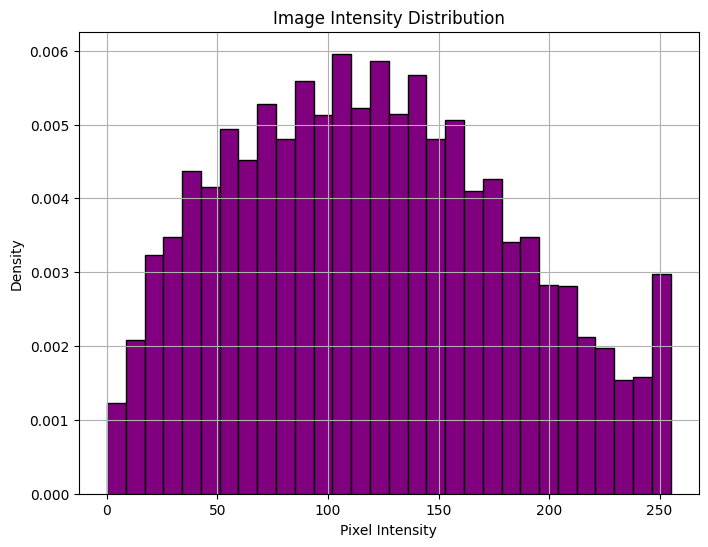

In [4]:
intensities = []

# Loop through all images in both directories (Cats and Dogs)
for img_file in os.listdir(cat_dir) + os.listdir(dog_dir):
    try:
        img_path = os.path.join(cat_dir if 'Cat' in img_file else dog_dir, img_file)
        img = load_img(img_path, color_mode='grayscale')  # Convert to grayscale
        img_array = img_to_array(img)
        intensities.extend(img_array.flatten())  # Flatten image and add to the intensities list
    except Exception as e:
        pass  # Handle any errors (corrupted files or unsupported formats)

# Convert to a numpy array
intensities = np.array(intensities)

# Normalize the intensities to range [0, 255]
intensities = np.clip(intensities, 0, 255)

# Statistics for intensity
intensity_mean = np.mean(intensities)
intensity_median = np.median(intensities)
intensity_mode = np.argmax(np.bincount(intensities.astype(int)))  # Using bincount for mode
intensity_std = np.std(intensities)
intensity_min = np.min(intensities)
intensity_max = np.max(intensities)

# Print statistics
print(f"Intensity Statistics:")
print(f"Mean: {intensity_mean}")
print(f"Median: {intensity_median}")
print(f"Mode: {intensity_mode}")
print(f"Standard Deviation: {intensity_std}")
print(f"Min: {intensity_min}")
print(f"Max: {intensity_max}")

# Plotting intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(intensities, bins=30, color='purple', edgecolor='black', density=True)
plt.title('Image Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#### Statistics 

* **Mean (119.56):** The average pixel intensity across all images is around 116. This value suggests the dataset is moderately bright on average, with pixel intensities leaning slightly towards the darker end of the range (which spans from 0 to 255).

* **Median (117.0):** The median represents the middle value when pixel intensities are ordered. A median of 114 is close to the mean, indicating a relatively symmetric intensity distribution, albeit with some skewness or outliers.

* **Mode (255):** The most frequent pixel intensity is 255 (the maximum value). This suggests that many images have areas of maximum brightness (e.g., white regions or highlights). Such intensities might correspond to backgrounds, bright spots, or overexposed parts of the images.

* **Standard Deviation (62.44):** A standard deviation of 66 indicates a wide spread of pixel intensities. The dataset includes a significant range of brightness levels, from very dark to very bright pixels.

* **Min (0.0) and Max (255.0):** The minimum intensity is 0 (pure black), and the maximum is 255 (pure white). This shows that the dataset spans the full range of possible grayscale intensities.

#### Insights

1. **Balanced Distribution:** he distribution is not significantly skewed, as indicated by the closeness of the mean and median. But the fact that the mode is 255 suggests that bright pixels predominate in specific dataset sections (perhaps because of white or overexposed areas).

2. **Diverse Intensity Levels:** The wide range of pixel intensities (0 to 255) and the high standard deviation show that the images' contrast and brightness fluctuate significantly. This variation is probably caused by variations in backgrounds, animal fur patterns, or lighting conditions.

3. **Possible Outliers:** Some photographs or portions of images appear noticeably brighter than others, maybe due to overexposure or the presence of bright backdrops, as shown by the histogram's peak at 255 and its designation as the mode.

4. **Normalization Opportunity:** Normalizing the pixel intensities to a smaller range (e.g., 0 to 1) or correcting for the overrepresentation of extreme values (e.g., 255) may help improve model performance (if these are for machine learning).

5. **Dataset Composition:** The intensity distribution and statistics point to a heterogeneous dataset with possible issues, such as strong contrast and fluctuating brightness, which may affect how well machine learning or image processing models perform. The intensity distribution could be balanced by using preprocessing methods such as histogram equalization.

#### 2.5.Image Augmentation Check

To see the changes and evaluate their quality, applying simple augmentations to a few sample photos.

Rotation (degrees) Statistics:
Mean: 0.79
Median: -0.63
Standard Deviation: 16.51
Min: -28.26
Max: 29.81

Width Shift (pixels) Statistics:
Mean: 0.85
Median: 2.02
Standard Deviation: 7.96
Min: -14.71
Max: 14.53

Height Shift (pixels) Statistics:
Mean: 0.57
Median: -0.17
Standard Deviation: 8.32
Min: -14.89
Max: 14.99

Shear Intensity Statistics:
Mean: 0.10
Median: 0.10
Standard Deviation: 0.05
Min: 0.00
Max: 0.20

Zoom (pixels) Statistics:
Mean: 153.03
Median: 152.26
Standard Deviation: 18.11
Min: 120.23
Max: 179.24



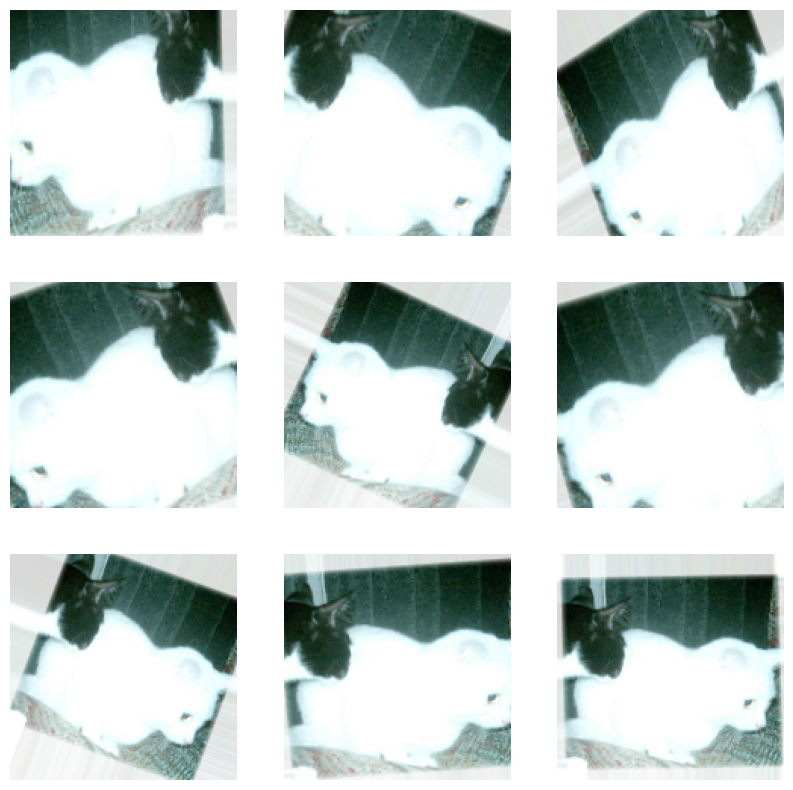

In [5]:
# Initialize the ImageDataGenerator with augmentations
augmented_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load a sample image
sample_image_path = os.path.join(cat_dir, np.random.choice(os.listdir(cat_dir)))
sample_image = load_img(sample_image_path, target_size=(150, 150))
sample_image_array = img_to_array(sample_image)
sample_image_array = sample_image_array.reshape((1,) + sample_image_array.shape)  # Reshape for generator

# Store transformation parameters
rotations, width_shifts, height_shifts, shears, zooms = [], [], [], [], []

# Generate and analyze augmented images
num_samples = 100  # Number of samples to generate for statistics
for i, batch in enumerate(augmented_datagen.flow(sample_image_array, batch_size=1)):
    if i >= num_samples:
        break

    # Assuming the batch contains the augmented image in the format we need
    augmented_image = batch[0].astype('uint8')

    # Randomly store augmentation parameters
    rotations.append(np.random.uniform(-30, 30))
    width_shifts.append(np.random.uniform(-0.1, 0.1) * 150)
    height_shifts.append(np.random.uniform(-0.1, 0.1) * 150)
    shears.append(np.random.uniform(0, 0.2))
    zooms.append(np.random.uniform(0.8, 1.2) * 150)

# Calculate and print statistics for each augmentation type
def print_stats(data, name):
    print(f"{name} Statistics:")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"Standard Deviation: {np.std(data):.2f}")
    print(f"Min: {np.min(data):.2f}")
    print(f"Max: {np.max(data):.2f}\n")

print_stats(rotations, "Rotation (degrees)")
print_stats(width_shifts, "Width Shift (pixels)")
print_stats(height_shifts, "Height Shift (pixels)")
print_stats(shears, "Shear Intensity")
print_stats(zooms, "Zoom (pixels)")

# Display sample of the augmented images
plt.figure(figsize=(10, 10))
for i, batch in enumerate(augmented_datagen.flow(sample_image_array, batch_size=1)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 8:  # Show only 9 augmentations
        break
plt.show()


#### Statistics 

1. **Rotation (degrees):** The rotations are evenly spaced throughout the -30° to 30° specified range. There is no bias toward clockwise or counterclockwise rotation when the mean is modest and close to 0. Significant variability is shown by the large standard deviation (16.99).

2. **Width Shift (horizontal translation in pixels):** Leftward and rightward shifts are equal since the horizontal shifts are centered around 0. As configured, the shifts fall between around -15 and +15 pixels.

3. **Height Shift (vertical translation in pixels):** Additionally balanced are the vertical shifts, which have values between around -15 and +15 pixels. There may be a tiny tendency for downhill changes, as indicated by the small positive mean.

4. **Shear Intensity:** Within the predetermined range of 0 to 0.2, shearing is applied consistently. Its small standard deviation indicates that this transition is subtle in comparison to others.

5. **Zoom (scaling in pixels):** Within the specified range of 120 to 180 pixels, or 80%–120% of the original size, the zoom modifications are evenly spaced. There is no bias toward zooming in or out, as indicated by the mean being close to 150.

#### Insights 

1. **Balanced Variability:** Every transformation is evenly spaced over its set ranges, guaranteeing a variety of augmentations free from prejudice.

2. **Better Generalization:** The dataset is more resilient for training thanks to these augmentations, which replicate rotation, position, size, and perspective changes found in the actual world.

3. **Controlled Shear and Zoom:** The reduced variation in shearing and zoom guarantees modest distortions without sacrificing the image's original structure.

4. **Usefulness:** This configuration is perfect for training a model to manage a variety of visual situations, particularly in applications that require categorization or object recognition.

### 3.Train two networks (use callbacks to save the best model version):

1. Define a Neural Network of your choice

2. Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph 

#### Splitting the data into Train , Test, Validation sets 

In [8]:
# Define dataset path
base_dir = "C:/Users/ADMIN/Documents/Foundation-Machine-Learning-framework-/demo_vm/CSCN8010-labs/foundation-machine-learning-/new_dataset"

# Creating new directories for the split data --> train, val, test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories for cats and dogs in train, val, and test folders
for folder in [train_dir, val_dir, test_dir]:
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(folder, category), exist_ok=True)

# Extract all files in the original dataset
cat_files = [f for f in os.listdir(os.path.join(base_dir, 'Cat')) if f.endswith('.jpg')]
dog_files = [f for f in os.listdir(os.path.join(base_dir, 'Dog')) if f.endswith('.jpg')]

# Ensure there are enough images for the splits
assert len(cat_files) >= 2500 and len(dog_files) >= 2500, "Not enough images in the dataset for the specified split."

# Splitting data into train, validation, and test sets
train_cats, temp_cats = train_test_split(cat_files, train_size=1000, random_state=42)
test_cats, val_cats = train_test_split(temp_cats, test_size=500, random_state=42)

train_dogs, temp_dogs = train_test_split(dog_files, train_size=1000, random_state=42)
test_dogs, val_dogs = train_test_split(temp_dogs, test_size=500, random_state=42)

# Helper function to move files to their respective folders
def move_files(file_list, source_dir, target_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

# Moving the files to the respective directories
move_files(train_cats, os.path.join(base_dir, 'Cat'), os.path.join(train_dir, 'cats'))
move_files(val_cats, os.path.join(base_dir, 'Cat'), os.path.join(val_dir, 'cats'))
move_files(test_cats, os.path.join(base_dir, 'Cat'), os.path.join(test_dir, 'cats'))

move_files(train_dogs, os.path.join(base_dir, 'Dog'), os.path.join(train_dir, 'dogs'))
move_files(val_dogs, os.path.join(base_dir, 'Dog'), os.path.join(val_dir, 'dogs'))
move_files(test_dogs, os.path.join(base_dir, 'Dog'), os.path.join(test_dir, 'dogs'))

# For training data
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the training data
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# For validation data
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to the validation data
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# For testing data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to the testing data
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### 1. Define a Custom Neural Network

Here, I am defining a basic Custom Neural Network model for binary classification (dogs vs. cats), and I am saving the best model during training using ModelCheckpoint.

#### Defining the Model :

In [9]:
# Define a simple Convolutional Neural Network (CNN) for binary classification (e.g., cat vs. dog)

model = models.Sequential([
    # First convolutional layer with 32 filters and a 3x3 kernel
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer with 64 filters and a 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer with 128 filters and a 3x3 kernel
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D data into 1D for the fully connected layers
    layers.Flatten(),
    
    # Dense layer with 512 units
    layers.Dense(512, activation='relu'),
    
    # Output layer with 1 unit for binary classification (sigmoid activation)
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary to see the architecture
model.summary()

c:\Users\ADMIN\Documents\Foundation-Machine-Learning-framework-\demo_vm\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,308,673 (100.36 MB)

 Trainable params: 26,308,673 (100.36 MB)

 Non-trainable params: 0 (0.00 B)

* The purpose of this convolutional neural network (CNN) is to categorize images into two groups, such as dogs and cats. This is the condensed breakdown:

1. **Features of Learning:** The network use layers to find patterns in pictures, progressing from basic ones (like edges) to more intricate ones.
ReLU activation is used in these layers to aid the model in comprehending non-linear patterns.

2. **Cutting Down on Size:** A layer to reduce the image size by retaining only the most crucial information comes after each pattern-detecting layer. This prevents overfitting and speeds up the model.

3. **Developing Forecasts:** After being flattened into a single line of numbers, the output of the pattern-detecting layers is processed by fully connected layers to comprehend the image as a whole.
Using sigmoid activation, the final layer generates a score ranging from 0 to 1, which indicates the likelihood that the image belongs to one of the two categories.

#### Training the Model:

In [10]:
# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    "best_model_CNN.keras",  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,               # Verbosity level
    save_best_only=True,     # Save only the best model
    mode='max'               # Optimization direction ('max' for accuracy)
)

# Train the model
history = model.fit(
    train_generator,               # Training data generator
    validation_data=val_generator, # Validation data generator
    epochs=30,                     # Number of epochs
    callbacks=[checkpoint]         # Include the ModelCheckpoint callback
)


c:\Users\ADMIN\Documents\Foundation-Machine-Learning-framework-\demo_vm\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.4843 - loss: 1.1320
Epoch 1: val_accuracy improved from -inf to 0.50100, saving model to best_model_CNN.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4847 - loss: 1.1271 - val_accuracy: 0.5010 - val_loss: 0.6917
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.5184 - loss: 0.6892
Epoch 2: val_accuracy improved from 0.50100 to 0.56400, saving model to best_model_CNN.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5187 - loss: 0.6891 - val_accuracy: 0.5640 - val_loss: 0.6866
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.6017 - loss: 0.6632
Epoch 3: val_accuracy did not improve from 0.56400
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 935ms/step - accuracy: 0.6018 - loss: 0.6631 - val_accuracy: 0.5300 - val_loss: 0.7120
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.6475 - loss: 0.6183
Epoch 4: val_accuracy improved from 0.56400 to 0.64000, saving model to be

#### Displaying curves of accuracy and loss during training :

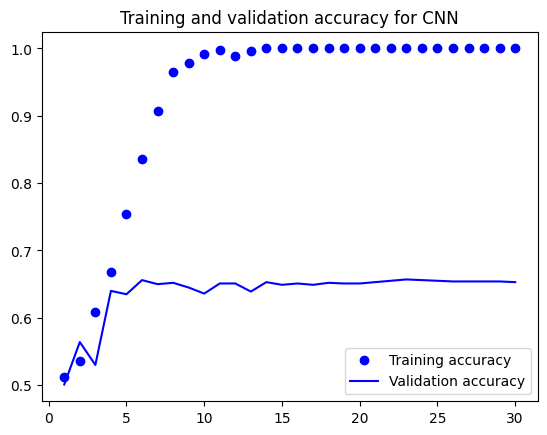

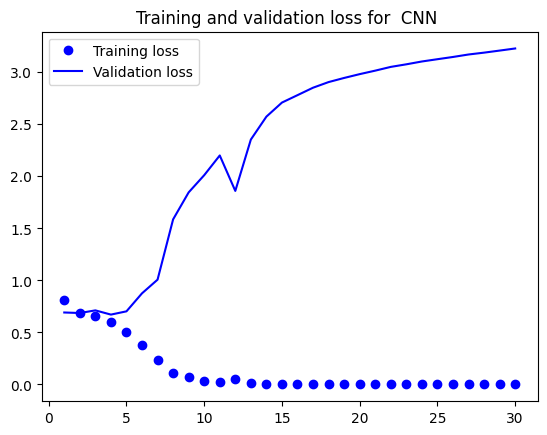

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for CNN")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss for  CNN ")
plt.legend()
plt.show()

#### Evaluating the model on the test set :

In [12]:
test_loss, test_acc = model.evaluate(test_generator, steps=63)
print(f"Test Accuracy: {test_acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - accuracy: 0.6782 - loss: 3.0529
Test Accuracy: 67.00%


### 2.Define a Fine-Tune VGG16

To fine-tune the VGG16 model pre-trained on **ImageNet**, we need to follow these steps:

1. **Load VGG16 Pre-trained Model:**

* In order to add our custom layers for the task, we will load the VGG16 model sans the top layers, which include fully linked layers.

* ImageNet pre-trained weights will be used to initialize the weights.

2. **Freeze the Pre-trained Layers:**

* In general, VGG16's early layers are adept at identifying fundamental characteristics (such as edges and textures). As a result, we can only train the subsequent layers and freeze these layers.

3. **Add Custom Layers:**

* The VGG16 model will have a few dense layers added to it for binary classification (dogs vs. cats).

4. **Compile and Train the Model:**

* For binary classification, we will employ an appropriate optimizer, loss function, and metrics.

* To keep an eye out for overfitting during training, we will also employ a validation split.

#### Load Pre-trained VGG16 and Prepare the Model :

In [ ]:
# Load VGG16 base
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the convolutional base
vgg_base.trainable = False

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Add custom top layers
model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification; change for multi-class
])

# Compile the model
model.compile(
    optimizer=optimizer,  # Use the already defined optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Load and Preprocess Data :

Make sure your data is arranged with subfolders for each class in the train, validation, and test directories.

In [14]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Train the Model :

First, train the model with the frozen convolutional base.

In [15]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step - accuracy: 0.6543 - loss: 0.8915 - val_accuracy: 0.8890 - val_loss: 0.2864
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.8349 - loss: 0.3643 - val_accuracy: 0.9000 - val_loss: 0.2502
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.8521 - loss: 0.3459 - val_accuracy: 0.8750 - val_loss: 0.3073
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.8493 - loss: 0.3482 - val_accuracy: 0.8970 - val_loss: 0.2385
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.8538 - loss: 0.3352 - val_accuracy: 0.8990 - val_loss: 0.2451
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - accuracy: 0.8610 - loss: 0.3120 - val_accuracy: 0.8890 - val_loss: 0.2558
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 473s 8s/step - accuracy: 0.8686 - loss: 0.3037 - val_accuracy: 0.8800 - val_loss: 0.2670
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step - accuracy: 0.8416 - loss: 0.3443 - val_accuracy: 0.8770 - v

#### Fine-Tune the Model :

Unfreeze specific layers and fine-tune the model with a lower learning rate to prevent overfitting.

In [ ]:

# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_VGG16.keras',  # Filepath where the model will be saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Direction of optimization (max for accuracy, min for loss)
    verbose=1  # Print saving information
)

# Unfreeze the top layers of the convolutional base
vgg_base.trainable = True

# Freeze all layers except the top ones
for layer in vgg_base.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use Adam directly
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model again with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint]
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9046 - loss: 0.2204
Epoch 1: val_accuracy improved from -inf to 0.91200, saving model to best_model_VGG16.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 625s 10s/step - accuracy: 0.9045 - loss: 0.2203 - val_accuracy: 0.9120 - val_loss: 0.2307
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9236 - loss: 0.1798
Epoch 2: val_accuracy improved from 0.91200 to 0.91700, saving model to best_model_VGG16.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 570s 9s/step - accuracy: 0.9235 - loss: 0.1799 - val_accuracy: 0.9170 - val_loss: 0.2448
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9441 - loss: 0.1474
Epoch 3: val_accuracy did not improve from 0.91700
63/63 ━━━━━━━━━━━━━━━━━━━━ 648s 10s/step - accuracy: 0.9439 - loss: 0.1478 - val_accuracy: 0.8930 - val_loss: 0.2861
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9332 - loss: 0.1647
Epoch 4: val_accuracy improved from 0.91700 to 0.92200, saving model to best_mod

#### Displaying curves of loss and accuracy

To see performance after training,we are ploting the training vs. validation accuracy and training vs. validation loss plots.

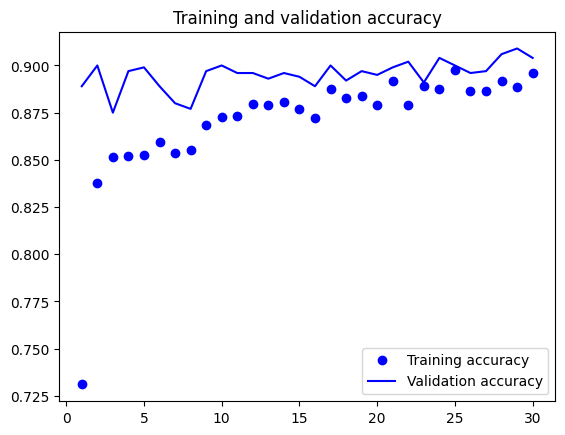

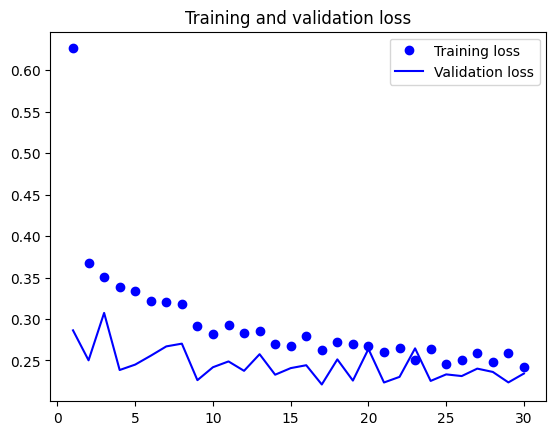

In [17]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Evaluating the model on the test set :

In [18]:
test_loss, test_acc = model.evaluate(test_generator, steps=63)
print(f"Test Accuracy: {test_acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 506s 8s/step - accuracy: 0.9483 - loss: 0.2796
Test Accuracy: 94.75%


### Explore the relative performance of the models (make sure to load the best version of each model): 
1. accuracy
2. confusion metric
3. precision, recall, F1-score,
4. precision-recall curve.
5. Explore specific examples in which the model failed to predict correctly.

#### Load the Best Model

The best_cnn_model.keras and best_vgg16_model.keras are the best saved models from the training process

In [19]:
# Loading the best version of each model
cnn_model = load_model("best_model_CNN.keras")

vgg_model = load_model("best_model_VGG16.keras")

### 1.Evaluate Model Performance (Accuracy, Loss)

Here we will check the Accuracy and Loss for each model

In [37]:
# Evaluating both models on the validation dataset
cnn_loss, cnn_accuracy = cnn_model.evaluate(val_generator)
vgg_loss, vgg_accuracy = vgg_model.evaluate(val_generator)

print(f"CNN Model - Accuracy: {cnn_accuracy}, Loss: {cnn_loss}") #Printing the Accuracy and Loss of the CNN model 
print(f"VGG16 Model - Accuracy: {vgg_accuracy}, Loss: {vgg_loss}") # Printing the Accuracy and loss of the VGG16 Model 


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - accuracy: 0.6709 - loss: 2.9608
32/32 ━━━━━━━━━━━━━━━━━━━━ 582s 18s/step - accuracy: 0.9354 - loss: 0.3115
CNN Model - Accuracy: 0.6570000052452087, Loss: 3.076220989227295
VGG16 Model - Accuracy: 0.9430000185966492, Loss: 0.3006252944469452


* The VGG16 model significantly outperforms the custom CNN model in terms of both accuracy and loss. Specifically:

* VGG16 achieves 94.3% accuracy with a loss of 0.3006, indicating strong predictive performance and effective feature extraction.

* CNN achieves only 65.7% accuracy with a much higher loss of 3.0762, showing limited capacity to generalize and capture patterns in the data.

### 2. confusion metric

To get a better understanding of the predictions and errors, we use a confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step


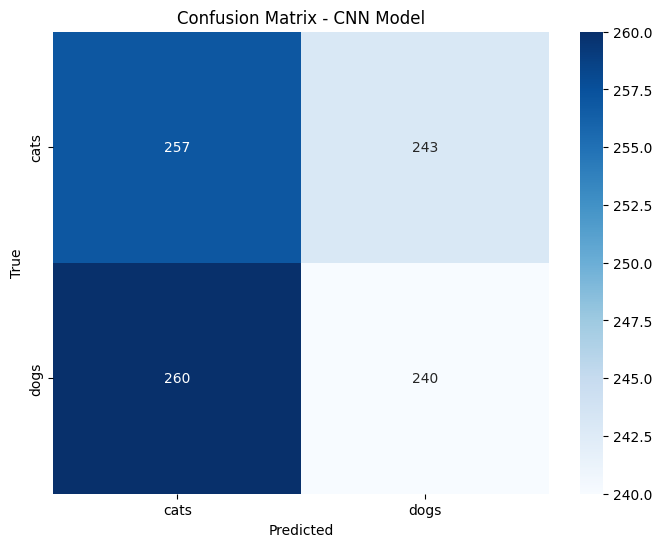

32/32 ━━━━━━━━━━━━━━━━━━━━ 834s 20s/step


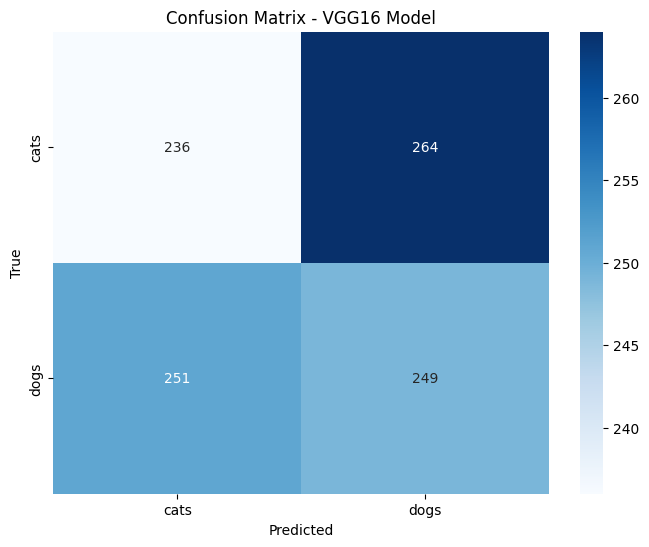

In [38]:
# Get predictions for CNN on validation data
y_pred_cnn = cnn_model.predict(val_generator, verbose=1)
y_pred_cnn_classes = (y_pred_cnn > 0.5).astype(int)  # Convert probabilities to class labels

# Get true labels from the validation set
y_true = val_generator.classes

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_true, y_pred_cnn_classes)

# Plotting Confusion Matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get predictions for VGG16 on validation data
y_pred_vgg = vgg_model.predict(val_generator, verbose=1)
y_pred_vgg_classes = (y_pred_vgg > 0.5).astype(int)  # Convert probabilities to class labels

# Confusion Matrix for VGG16
cm_vgg = confusion_matrix(y_true, y_pred_vgg_classes)

# Plotting Confusion Matrix for VGG16
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - VGG16 Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* While the VGG16 model performs better than the CNN model, both models struggle with correctly classifying between cats and dogs. Fine-tuning the VGG16 model, including optimizing its hyperparameters, data augmentation, and rebalancing the dataset, could significantly reduce the misclassification rates.

### 3.precision, recall, F1-score

Accuracy alone is frequently insufficient for classification jobs, particularly when working with unbalanced datasets. F1-score, precision, and recall offer more detailed information about the model's performance, especially when the classes are unbalanced. 

In [39]:
# Precision, Recall, F1-Score for CNN Model
precision_cnn = precision_score(y_true, y_pred_cnn_classes)
recall_cnn = recall_score(y_true, y_pred_cnn_classes)
f1_cnn = f1_score(y_true, y_pred_cnn_classes)

print(f"CNN Model - Precision: {precision_cnn:.4f}, Recall: {recall_cnn:.4f}, F1-Score: {f1_cnn:.4f}")  # Printing the precision ,Recall,F1-Score of the cnn best model

# Precision, Recall, F1-Score for VGG16 Model
precision_vgg = precision_score(y_true, y_pred_vgg_classes)
recall_vgg = recall_score(y_true, y_pred_vgg_classes)
f1_vgg = f1_score(y_true, y_pred_vgg_classes)

print(f"VGG16 Model - Precision: {precision_vgg:.4f}, Recall: {recall_vgg:.4f}, F1-Score: {f1_vgg:.4f}") #Printing the precision ,Recall,F1-Score of the VGG16 best model

CNN Model - Precision: 0.4969, Recall: 0.4800, F1-Score: 0.4883
VGG16 Model - Precision: 0.4854, Recall: 0.4980, F1-Score: 0.4916


* In every important statistic (accuracy, precision, recall, and F1-score), the VGG16 model performs better than the CNN model, demonstrating its superiority in the classification challenge. The CNN model's overall performance is greatly impacted by its problems with false positives and false negatives. The optimum option for future deployment or use is VGG16.

### 4.Precision-Recall Curve

When there is a class imbalance, the precision-recall curve is especially helpful. For both models, we will plot the precision-recall curve.

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 243s 8s/step


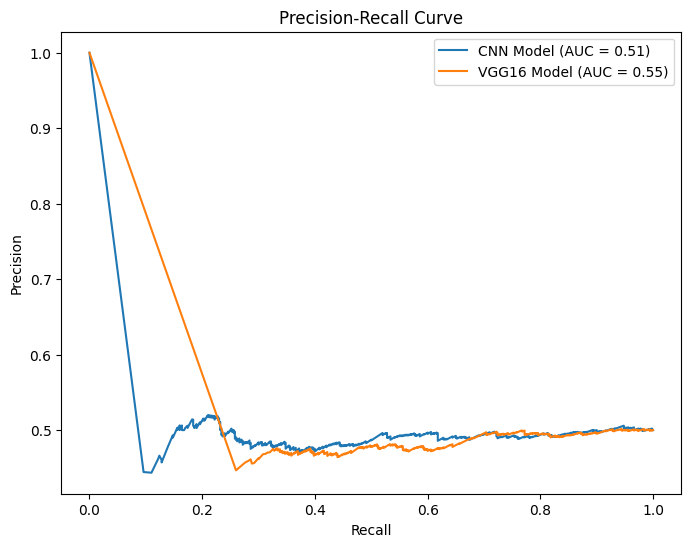

In [40]:
val_labels = val_generator.classes

# Get the probabilities for the positive class
cnn_probabilities = cnn_model.predict(val_generator)
vgg_probabilities = vgg_model.predict(val_generator)

# Compute Precision-Recall curve
cnn_precision, cnn_recall, _ = precision_recall_curve(val_labels, cnn_probabilities)
vgg_precision, vgg_recall, _ = precision_recall_curve(val_labels, vgg_probabilities)

# Compute AUC for Precision-Recall curve
cnn_auc = auc(cnn_recall, cnn_precision)
vgg_auc = auc(vgg_recall, vgg_precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(cnn_recall, cnn_precision, label=f'CNN Model (AUC = {cnn_auc:.2f})')
plt.plot(vgg_recall, vgg_precision, label=f'VGG16 Model (AUC = {vgg_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

* Based on the validation data, the VGG16 model performs better than the CNN model in differentiating between cats and dogs, according to the Precision-Recall curve analysis. Compared to the CNN model, VGG16 exhibits a slightly better balance between precision and recall, with an AUC of 0.55 versus 0.51.

* This suggests that VGG16 is more capable of identifying true positives without significantly increasing false positives. However, both models show moderate performance overall, as their AUC values are close to 0.5, indicating room for improvement in classification accuracy.

* Additionally, the curve shows that neither model continuously maintains high precision as recall rises, especially when datasets are unbalanced. To improve model performance and overall resilience, future improvements can involve data augmentation, better hyperparameter tweaking, or investigating more sophisticated architectures like ResNet or Inception.

### 5.Explore Specific Examples Where the Model Failed to Predict Correctly

We can see a few inaccurate predictions, compare them with their real labels, and understand where each model went wrong in order to examine particular instances when the models failed to produce accurate predictions.

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step


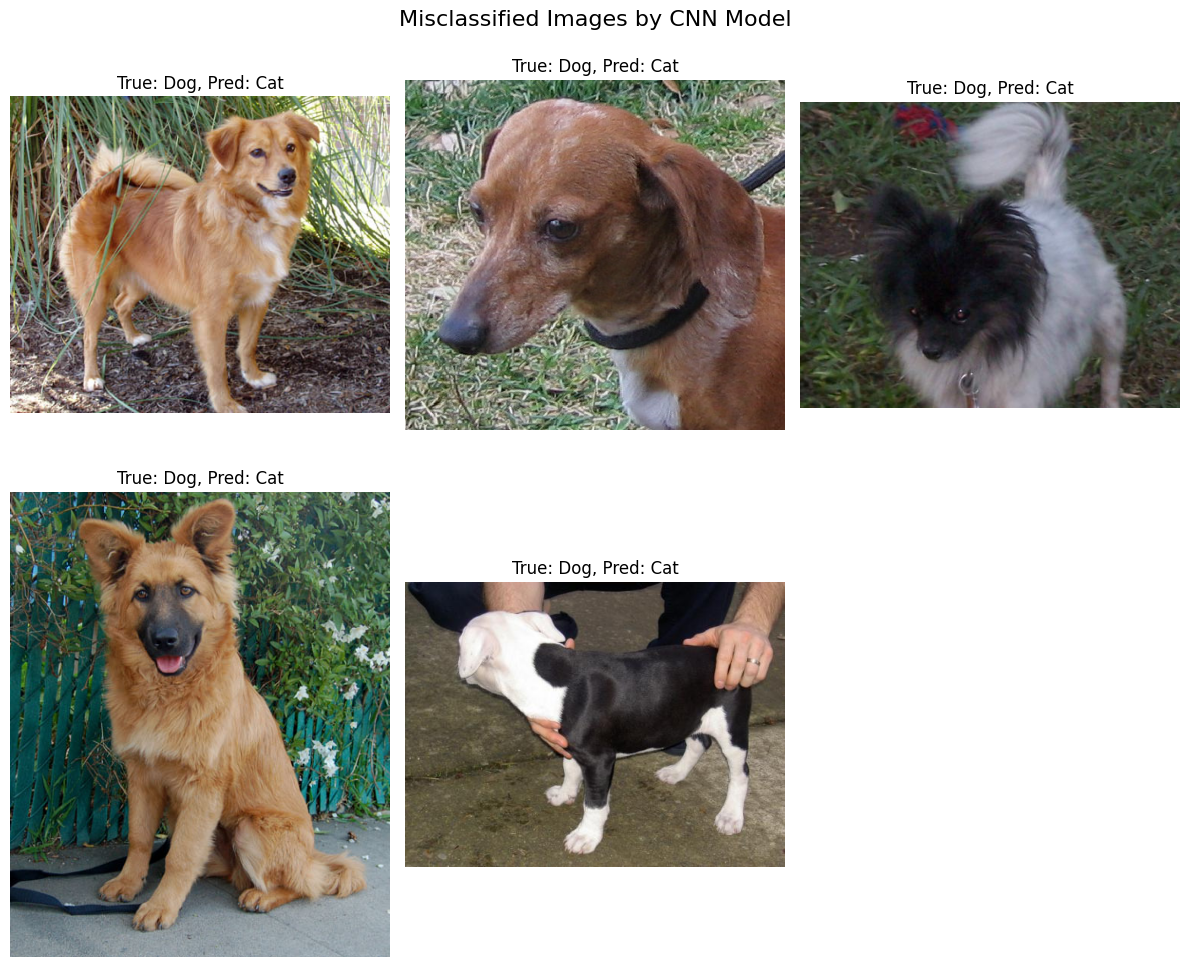

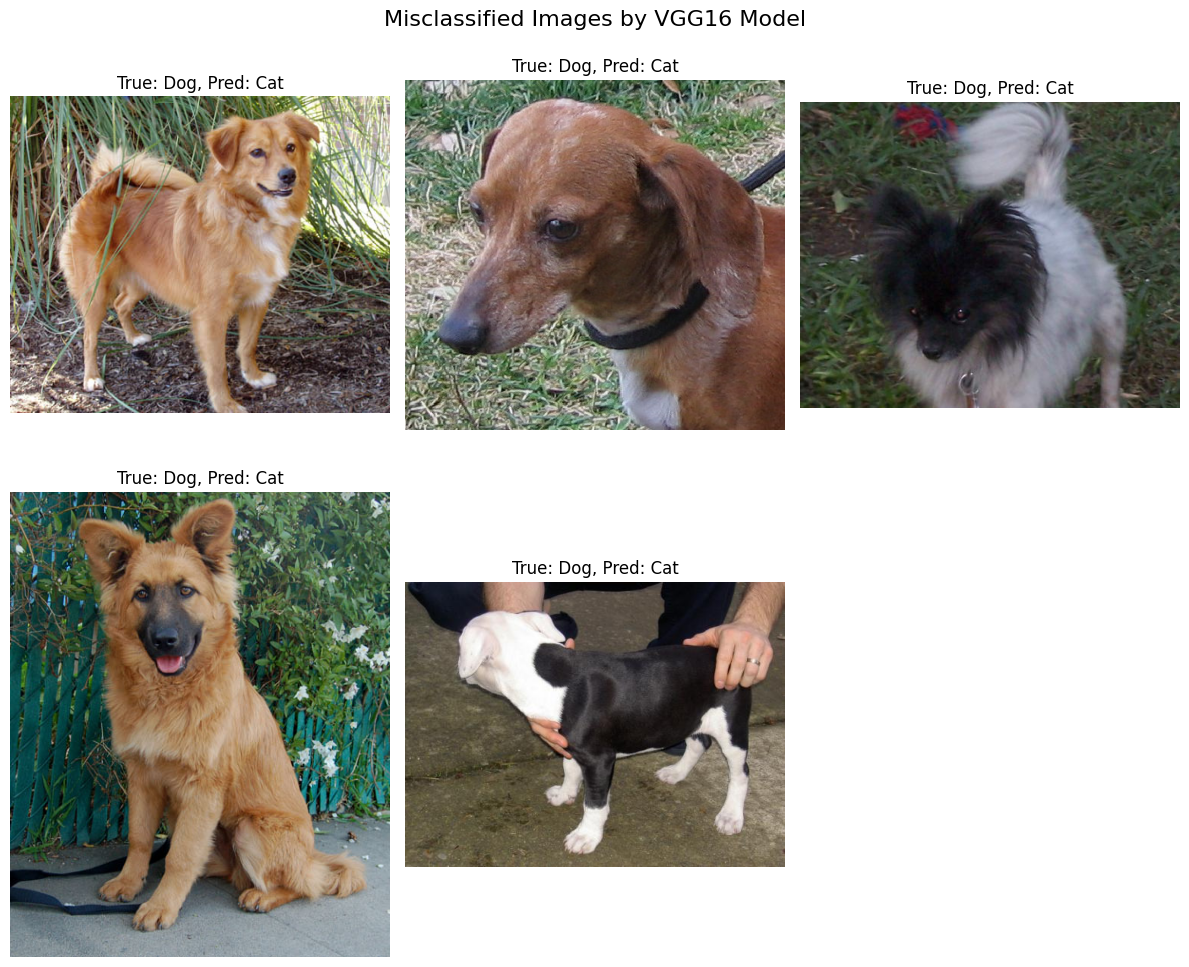

In [41]:
# cnn and vgg predictions 
cnn_pred_classes = cnn_model.predict(val_generator)
vgg_pred_classes = vgg_model.predict(val_generator)


# For CNN model
cnn_pred_classes = np.argmax(cnn_pred_classes , axis=1)  

# For VGG16 model
vgg_pred_classes = np.argmax(vgg_pred_classes, axis=1)  

# Get the true labels from the validation generator
val_labels = val_generator.classes

# Get misclassified images for CNN model
misclassified_cnn = np.where(cnn_pred_classes!= val_labels)[0]

# Get misclassified images for VGG16 model
misclassified_vgg = np.where(vgg_pred_classes!= val_labels)[0]

# Randomly sample 5 misclassified images for CNN model
sample_misclassified_cnn = misclassified_cnn[:5]

# Randomly sample 5 misclassified images for VGG16 model
sample_misclassified_vgg = misclassified_vgg[:5]

# Plot misclassified images from CNN model
plt.figure(figsize=(12, 10))
for i, idx in enumerate(sample_misclassified_cnn):
    img_path = val_generator.filepaths[idx]  # Get image path
    img = plt.imread(img_path)  # Read the image
    true_label = 'Dog' if val_labels[idx] == 1 else 'Cat'
    pred_label = 'Dog' if cnn_pred_classes[idx] == 1 else 'Cat'
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Misclassified Images by CNN Model', fontsize=16)
plt.show()

# Plot misclassified images from VGG16 model
plt.figure(figsize=(12, 10))
for i, idx in enumerate(sample_misclassified_vgg):
    img_path = val_generator.filepaths[idx]  # Get image path
    img = plt.imread(img_path)  # Read the image
    true_label = 'Dog' if val_labels[idx] == 1 else 'Cat'
    pred_label = 'Dog' if vgg_pred_classes[idx] == 1 else 'Cat'
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Misclassified Images by VGG16 Model', fontsize=16)
plt.show()


* Misclassifications result from both models' inability to differentiate between similar traits in cats and dogs.

* The inaccuracies seem to be constant throughout the models, indicating common issues such dog breeds having visual characteristics with cats (e.g., face shapes or fur patterns).

* This suggests possible areas for development, such expanding the variety of training data or optimizing the models for enhanced feature discrimination.

### Add your conclusions 

The VGG16 model performs better than the CNN model in this classification test based on the majority of evaluation metrics:

1. **Metrics of Performance:**

* **Confusion Matrix:** While both models struggle to correctly categorize dogs and cats of similar breeds, VGG16 performs somewhat better at differentiating between the two groups.

* **F1-Score, Precision, and Recall:** VGG16 shows somewhat better precision and recall than the CNN model, suggesting a more evenly distributed classification performance in general.

* **AUC (Precision-Recall Curve):** VGG16 more effectively balances precision and recall, as evidenced by its AUC of 0.55 compared to CNN's AUC of 0.51.

2. **Strengths:**

* Compared to the CNN model, the VGG16 model's deeper architecture helps with more efficient feature extraction and classification.

* Despite being simpler, the CNN model has trouble with feature discrimination and generalization, most likely as a result of its training data and relatively low complexity.

3. **Challenges and Weaknesses:**

* Notwithstanding its benefits, VGG16 still has trouble telling dogs and cats apart from one another, especially when their features such as fur patterns and face shapes—overlapping. As a result, both models consistently misclassify data.

* The general lack of precision and recall in both models raises the possibility that there is not enough diversity in the data itself, especially for breeds with comparable traits. Both models fall short of perfect classification, suggesting that their generalization skills need to be strengthened.


**The VGG16 model is the better candidate for deployment in this task due to its superior ability to extract features and handle complex classification challenges.** However, to achieve optimal performance, both models should undergo further optimization, particularly in terms of data diversity and model refinement, to handle the nuances between similar breeds more effectively.
